# Table of Contents

1. [Introduction](#introduction)
  * [Quntile Regression](#qr)
2. [Data Exploration](#exploration)
3. [Price Estimation](#estimation)
  * [Preprocessing](#preprocessing)
  * [Training and Testing the Models](#models)
      * [Tree-based models](#treebased)
          * [Linear Regression (and testing its assumptions)](#lr)
          * [Quantile Regression (LightGBM)](#lgbm)
      * [Neural Network](#nn)
  * [Comparison](#comparison)
4. [References](#ref)



# Introduction <a name="introduction"></a>

In this notebook, we want to explore the [Avocado Prices ](https://www.kaggle.com/neuromusic/avocado-prices)dataset in Kaggle, and also predict three quantiles for the price, using Quantile Regression. This notebook is inspired by these great posts from [Ethen Liu](http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html#Quantile-Regression-With-LightGBM) and [Carlos Souza](https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only).

## Quantile Regression <a name="qr"></a>

**What is it? How is it different from linear regression?**

Qunatile Regression is a type of regression analysis. Similar to linear regression, it tries to find an association between one or more explanatory variables and a continuous outcome. The main difference is that instead of mean of outcome, we are more interested in predicting a specific quantile (or quantiles) of the distribution of outcome. 

>Quantile regression is not a regression estimated on a quantile, or subsample of data as the name may suggest. Quantile methods allow the analyst to relax the common regression slope assumption. In OLS regression, the goal is to minimize the distances between the values predicted by the regression line and the observed values. In contrast, quantile regression differentially weights the distances between the values predicted by the regression line and the observed values, then tries to minimize the weighted distances [[3](#qrref)].



**What are the benefits of using QR?**

* It is useful when we are interested in predicting an interval rather than one value. One of the scenarios in which we might be interested in an interval is knowing uncertainity behind a point estimation. Here are two examples of such scenario in [estimating delivery time at Instacart](https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb) 
 and [estimating taxi fare in NY](https://brendanhasz.github.io/2018/12/15/quantile-regression).
* QR can be used when [assumptions of linear regression](https://en.wikipedia.org/wiki/Linear_regression#Assumptions) are not met.

 >The main advantage of quantile regression methodology is that the method allows for understanding relationships between variables outside of the mean of the data,making it useful in understanding outcomes that are non-normally distributed and that have nonlinear relationships with predictor variables [[3](#qrref)].

 (some violations of linear regression assumptions for this dataset will be mentioned in the rest of the notebook)
* It is more robust to outliers compared to linear regression with least squared error. In the latter, outliers far from the mean can bias the predicted outcome.

# Setup

In [ ]:
import re
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import scipy.stats as stats
from geopy.geocoders import Nominatim
import calendar
from statsmodels.stats.stattools import durbin_watson

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from lightgbm import LGBMRegressor,plot_importance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../usr/lib/utility_script/functions_for_avocado_notebook.py", dst = "../working/functions_for_avocado_notebook.py")

# import all our functions
from functions_for_avocado_notebook import *

# Data Exploration <a name='exploration'></a>

In [ ]:
avocados_df = pd.read_csv("../input/avocado-prices/avocado.csv")

This is the information about columns provided with the dataset:

* Date - The date of the observation
* AveragePrice - the average price of a single avocado
* type - conventional or organic
* year - the year
* Region - the city or region of the observation
* Total Volume - Total number of avocados sold
* 4046 - Total number of avocados with PLU 4046 sold (small Hass)
* 4225 - Total number of avocados with PLU 4225 sold (large Hass)
* 4770 - Total number of avocados with PLU 4770 sold (extra large Hass)

(This [link](http://indexfresh.com/retail-foodservice/brands/packaging/plus/) provides information about the PLU codes)

We can take advantage of pandas profiling to analyse the columns


In [ ]:
profile = ProfileReport(avocados_df, title="Avocado Price Dataset Profile")
profile.to_notebook_iframe()

Some intersting things we can see in the correlation section:
* AveragePrice has positive corr. with year and negative corr. with most other numeric variables (with Pearson's r correlation) .

* QR is one alternative when linear regression assumptions don't hold. One of those assumptions is "Lack of perfect multicollinearity in the predictors". This means that the predictors of AveragePrice shouldn't correlate with each other. But in the correlation heatmap we see that there is actually high positive correlation between most of the predictors. 

* AveragePrice also has noticable correlation with the categorical values, region and type (Phik correlation).


Next, we'll see the pair-wise relationship between the variables. We can see that the linearity assumption for linear regression is violated. For example, the relationship between AveragePrice (the outcome) and 4046 (predictor) is not linear (we will test this assumption again with residuals later).

In [ ]:
fig = px.scatter_matrix(avocados_df, dimensions=avocados_df.columns.difference(['region']), template='plotly_white',
    color="AveragePrice",opacity = 0.7, title='Avocado Data set', height=1500)
fig.show()

We saw statistical information about columns and correlaiton among numeric variables with pandas profiling. We are also interested in correlation of price with categorical vaules.

In [ ]:
fig = px.box(avocados_df, y="AveragePrice", x="type", template='plotly_white', 
             title="AveragePrice distribution by avocado type", height=400,width=400)
fig.show()

The box plot shows that organic avocados are more expensive in general (shocking, I know).

It would be interesting to see if there are any trends over time for the price with respect to the type.

In [ ]:
avocados_df['Date'] = pd.to_datetime(avocados_df['Date'])
fig = go.Figure()
colors = {2015:'blue',2016:'green',2017:'darkorange',2018:'red'}
for y in avocados_df['year'].unique():
    ydf = avocados_df[avocados_df['year']==y].copy()
    ydf['month'] = ydf['Date'].dt.month
    ydf = ydf.groupby(['month','type'],as_index=False).median()
    ydf['month'] = ydf['month'].apply(lambda x: calendar.month_abbr[x])
    organics = ydf[ydf['type']=='organic']
    fig.add_traces(go.Scatter(x=organics['month'], y=organics['AveragePrice'], mode='lines', 
                              name = str(y)+"-organic",line_dash='dot',line_color=colors[y]))
    conventionals = ydf[ydf['type']=='conventional']
    fig.add_traces(go.Scatter(x=conventionals['month'], y=conventionals['AveragePrice'], mode='lines', 
                              name = str(y)+"-conventional",line_dash='longdashdot',line_color=colors[y]))

fig.update_layout(title='AveragePrice by year, month and type',template='plotly_white',
                   xaxis_title='Month',
                   yaxis_title='Median AveragePrice')
fig.show()

It looks like every year the avocados are most expensive between August-Novermber. December-Febuary are the best months to buy avocados. There is a steep rise in the price in 2017. Here is an article from May 2017 explaining why --> [Avocado prices at record high due to reduced harvests](https://www.bbc.com/news/business-39768480) 

Next, we are interested in relationship between price and region.

In [ ]:
avocados_df['region'].unique()

It looks like some of the regions including "TotalUS,West,Northeast" are acutally an aggregation of places.

I'd like to show the regions on a map.  We'll need the latitude and longitude of each region for the map. We can find that using geolocator libarary and the region name. But this libarary wouldn't work with the way regions are named in this dataset. So we first make them valid (for example, "SanFrancisco" to "San Francisco").

In [ ]:
avocados_df['region'] = avocados_df['region'].apply(split_by_capital_letter)
avocados_df['region']= avocados_df['region'].replace(['West Tex New Mexico'], 'West Texas New Mexico')

In [ ]:
city_location_obj_dict = get_geo_location_by_city(avocados_df,'region')
avocados_df['longitude'] = avocados_df['region'].apply(lambda region: city_location_obj_dict[region].longitude)
avocados_df['latitude'] = avocados_df['region'].apply(lambda region: city_location_obj_dict[region].latitude)

In [ ]:
# We'll remove the aggregaations like "TotalUS" for plotting price distribution on map.
individual_regions_df = avocados_df[~avocados_df.region.isin(['Midsouth', 'Total U S', 'West', 'Northeast','South Central', 'Southeast'])]
avocado_region_group = individual_regions_df.groupby(['region'],as_index=False).median()
price_quantile_cuts = pd.qcut(individual_regions_df['AveragePrice'], 3)
cut_bins = list(price_quantile_cuts.unique())
cut_bins.sort(key = lambda interval:interval.right)

colors = ["gold","coral","crimson"]
scale = 100
fig = go.Figure()

for i in range(len(cut_bins)):
    upper_lim = cut_bins[i].right
    lower_lim = cut_bins[i].left

    df_sub = avocado_region_group[(avocado_region_group["AveragePrice"]>lower_lim) & (avocado_region_group["AveragePrice"]<=upper_lim)]
    name = "{0}<Median AveragePrice<={1}".format(lower_lim,upper_lim)

    fig.add_trace(go.Scattergeo(lat=df_sub['latitude'],lon=df_sub['longitude'],
                                text=df_sub['AveragePrice'].astype(str)+"<br>"+df_sub['region'],
                                marker={'size':df_sub['AveragePrice']*scale*(i+1),'color' : colors[i],'opacity':0.6,
                                        'line_color':'rgb(40,40,40)','line_width':0.5,'sizemode' : 'area'},
                                name = name))
    
fig.update_layout(title_text = '2015-2018 US Avocado Sales',showlegend = True,
                      geo ={'scope' : 'usa','landcolor' :'rgb(217, 217, 217)'})
fig.show()

So it looks like we shouldn't have much difficulty finding some cheap avocados in Dallas and Houston, and unsuprisingly, expensive ones in New York and San Francisco.

# Price Estimation<a name='estimation'></a>

## Preprocessing <a name='preprocessing'></a>
There are somethings we have to take care of before moving forward with fitting our models.
 


In [ ]:
# sort df by date, will need this sorting for plotting purpose later
avocados_df = avocados_df.sort_values(by=['Date'],ignore_index=True)

X = avocados_df.loc[:,avocados_df.columns!='AveragePrice'].copy()
y = avocados_df['AveragePrice'].copy()

### Remove redundancy

In [ ]:
#Removing aggregated columns/rows
X.drop(columns=['Total Bags','Total Volume'],inplace=True)
X = X[~X['region'].isin(['Midsouth', 'Total U S', 'West', 'Northeast','South Central', 'Southeast'])]
y = y[y.index.isin(X.index)]

### Dealing with outliers (if any)

In [ ]:
# among all the colums, the following I suspect we could find outliers in them. 
# the variance and other statistical info. found with pandas profiling seemed sketchy!
# also, in the pairwise scatter plot, if you look closely you can see some points just further away
# from everyone else in plots related to the following colomns
outlier_suspects = ['Unnamed: 0','4046','4225','4770','Small Bags','Large Bags','XLarge Bags']
outlier_index = find_outliers(X,outlier_suspects)

...[sigh]...great...<br>
But I actually want to keep them in the data. One of the advantagous of quantile regression is its robustness to outliers, and also not having any strict assumptions about distribution of variables.

### Normalizing numeric columns

In this notebook, first I want to use a simple linear regression with MSE loss, which does not require the numeric values to be normalized. Similarly, the quantile regressors with LightGBM trees do not require normalized values. So we can skip this step if we want to use only these models. However, I also want to try quantile regression with a nueral network which ideally would need the numeric values be in same scale for faster convergence. Since I decided to keep the outliers, scaling would be erroneous at this stage. So I decided not to do any scaling. In case the NN model convergence seemed to suffer from unscaled data, we'll reconsider this.

### Converting categorical columns to numeric

In [ ]:
# for avocado type, just change it to binary
X['type'] = X['type'].apply(lambda t:1 if t=='organic' else 0)
# For Date, we already have 'year' in data, so we extract month and day, and remove Date
X['Date'] = pd.to_datetime(X['Date'])
X['month'] = X['Date'].dt.month
X['day'] = X['Date'].dt.day
X.drop(columns=['Date'],inplace=True)
#we could just use the latitude and longitude found with geolocater, instead of region name.
X.drop(columns=['region'],inplace=True)

## Training and Testing the Models <a name='models'></a>

In [ ]:
quantile_alphas = [0.1, 0.5, 0.9]
X.rename(columns={'Unnamed: 0':'Unnamed'},inplace=True)

# Since we have a time component, I think it's not a good idea to shuffle the dataset
# in case the end goal is to predict prices in future, I think it makes more sense to
# train model on "past" data and test with future data
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False,random_state=94)
X_text = X_test.sort_index()#sort for plotting purpose
y_test = y_test.sort_index()
time_series = pd.to_datetime(X_test[["year", "month", "day"]].sort_index(),yearfirst=True)

### Tree-based Models <a name='models'></a>

#### Linear regression <a name='lr'></a>

In [ ]:
lgb_linear_regressor = linear_regressor(X_train, y_train)
linear_predictions = lgb_linear_regressor.predict(X_test)

The goal of this notebook is to try out quantile regression for predicting a price range. In the introduction I mentioned that QR is also useful when assumptions of linear regression are not met. We saw the volilation of the following assumptions in the [data exploration section](#violation):
1. Linear relationship between outcome and predictors (using pair-wise scatter plot)
2. Lack of perfect multicollinearity (using correlation heatmap)

Now that we have a linear regression model fitted on our data, we can test these assumptions [[5,7](#ref)]:
 1. Linearity
 2. Statistical independence of the errors
 3. homoscedasticity (constant variance) of the errors
 4. Normality of the error distribution.

In [ ]:
residuals = y_test - linear_predictions
linearity_test(y_test,linear_predictions,residuals)

>nonlinearity is usually most evident in a plot of observed versus predicted values or a plot of residuals versus predicted values, which are a part of standard regression output. The points should be symmetrically distributed around a diagonal line in the former plot or around horizontal line in the latter plot, with a roughly constant variance.

Neither of these plots looks symmentricall to me.

In [ ]:
autocorrelation_test(residuals)

In [ ]:
homoscedasticity_test(residuals)

>If the data are obtained in time (or space) sequence, a residuals vs. order plot helps to see if there is any correlation between the error terms that are near each other in the sequence. In general, residuals exhibiting normal random noise around the residual = 0 line suggest that there is no serial correlation.

I'm not expert in the matter, but to me, the residuals don't look randomly distributed.

In [ ]:
normality_test(residuals,'residuals')

As we investigated, assumptions that must be satisfied for using linear regression are violated. However, it's most likely because we kept the outliers in our dataset (though I think *Lack of perfect multicollinearity* has nothing to do with outliers). But if one is really keen on using LR, each of the voilated assumptions has a fix, and they're explained in references [[5,7](#ref)].

#### Quantile regression <a name='lgbm'></a>

In [ ]:
# We cannot predict more than one value with tree-based models, so we train one model per each quantile of interest
lgb_quantile_regressors = quantile_regressor(X_train, y_train,quantile_alphas)
quantile_predictions = predict(lgb_quantile_regressors, X_test)
plot_lgbm_train_test_loss(lgb_quantile_regressors,y_test,X_test,y_train,X_train)

The plot shows that each of the model trained for a specific quantile perform better on that quantile. For example lgb_10 does better on 10th quantile and worst on 90th. Train loss is also lower than test loss which is a sign of overfitting. We'll tweak the paramteres a bit to see if we can improve that. 

In [ ]:
lgb_quantile_regressors = quantile_regressor(X_train, y_train,quantile_alphas,
                                             lgb_params = {'num_leaves':5,'n_estimators':10, 'min_data_in_leaf':500,
                                                           'max_depth':5 ,'feature_fraction':0.5,'extra_trees':True})

In [ ]:
plot_lgbm_train_test_loss(lgb_quantile_regressors,y_test,X_test,y_train,X_train)

The train and test loss became slighlty closer after tunning the parameters.

### Neural Network <a name='nn'><a>

For quantile regression, I used this great notebook from [Carlos Souza](https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only). I made some changes like reducing the size and adding dropout, since the model was over-fitting on this dataset.

In [ ]:
# based on https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only
class QuantModel(nn.Module):
    def __init__(self, num_features,p=0.5,out_quantiles=3):
        super(QuantModel, self).__init__()
        self.dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_features)
        self.fc1 = nn.Linear(num_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_quantiles)

    def forward(self, x):
        x = self.batch_norm_num(x)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


def quantile_loss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

class NNDataset(Dataset):
    def __init__(self, X, y):
        self.features = X.copy().reset_index(drop=True).values.astype(np.float32)
        self.target = y.copy().reset_index(drop=True).values.astype(np.float32)
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
      return self.features[idx], self.target[idx]

In [ ]:
numeric_features = len(X.columns)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nn_quantile_regressor = QuantModel(numeric_features)
nn_quantile_regressor.to(device)

optimizer = torch.optim.SGD(nn_quantile_regressor.parameters(), lr=0.001,weight_decay=0.2)

batch_size= 128
epoch = 50

train_ds = NNDataset(X_train, y_train)
test_ds = NNDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

training_loss = []
test_loss = []
for e in range(epoch):
    epoch_loss = 0
    n_batches = 0

    # train
    nn_quantile_regressor.train()
    for x, y in train_dl:
        batch = y.shape[0]
        x = x.to(device)
        y = y.to(device)

        preds = nn_quantile_regressor(x)
        loss = quantile_loss(preds, y, quantile_alphas)

        optimizer.zero_grad()   
        loss.backward()         
        optimizer.step()    
        epoch_loss+=(loss.item()*batch)
        n_batches+=batch

    # test
    nn_quantile_regressor.eval()
    nn_quantile_predictions = nn_quantile_regressor(torch.Tensor(test_ds.features).to(device))
    validation_loss = quantile_loss(nn_quantile_predictions, torch.Tensor(test_ds.target).to(device), quantile_alphas)
    
    epoch_loss /= n_batches
    training_loss.append(epoch_loss)
    test_loss.append(validation_loss)

    if e % 10 == 0:
      print('epoch: {}  train loss: {}, validation loss: {}'.format(e, epoch_loss,validation_loss))

In [ ]:
plot_nn_train_test_loss(training_loss,test_loss)

Fortunately, the model managed to converge without normalizing the data.

## Comparison <a name='comparison'></a>

In [ ]:
quantile_predictions = predict(lgb_quantile_regressors, X_test)
plot_quantile_prediction(quantile_predictions, time_series, y_test,'LGBM')

In [ ]:
nn_quantile_predictions = nn_quantile_predictions.detach().cpu().numpy()
nn_quantile_predictions = {quantile_alphas[i]:pd.Series(nn_quantile_predictions.T[i],name='AveragePrice',index=X_test.index) for i in range(len(quantile_alphas))}
plot_quantile_prediction(nn_quantile_predictions, time_series, y_test,'Neural Network')

LGBM models have a lower loss compared to the NN model. It maybe due to lack of enough data for training a more powerful NN model. And looking at the plots, it looks like LGBM did better at the 90th quantile. Although both models didn't do very well for data in 2017, which I think it's fine because the reason for the peak in price (reduced avocado harvest in Mexico) wasn't something available in this dataset.

Now I'd like to use the LGBM model to predict price of avocados in New York for December 2020 (time of writing this notebook) and compare the prediction with real data. I used [mercato](https://www.mercato.com/) online grocery shopping website to find hass avocado(this is the variety the dataset is about) prices in three different neighborhoods of NY.

In [ ]:
question_df = pd.DataFrame({
'Unnamed: 0':[0,0],'4046' : [1,1],'4225' : [0,0],'4770' : [0,0],
'Small Bags':[0,0],'Large Bags':[1,1],'XLarge Bags':[0,0],
'type':[0,1], # 0 --> conventional, 1 --> organic
'year' : [2020,2020],'month':[12,12],'day':[18,18],
'longitude':[city_location_obj_dict['New York'].longitude,city_location_obj_dict['New York'].longitude],
'latitude':[city_location_obj_dict['New York'].latitude,city_location_obj_dict['New York'].latitude]})
ny_predictions = predict(lgb_quantile_regressors, question_df)

In the following shots, you can see the prices vary in different neighborhoods(from top to botton, Brooklyn, Manhattan and Queens) in just one city. This is why we dicided not to predict one price, and insted predict a price interval.

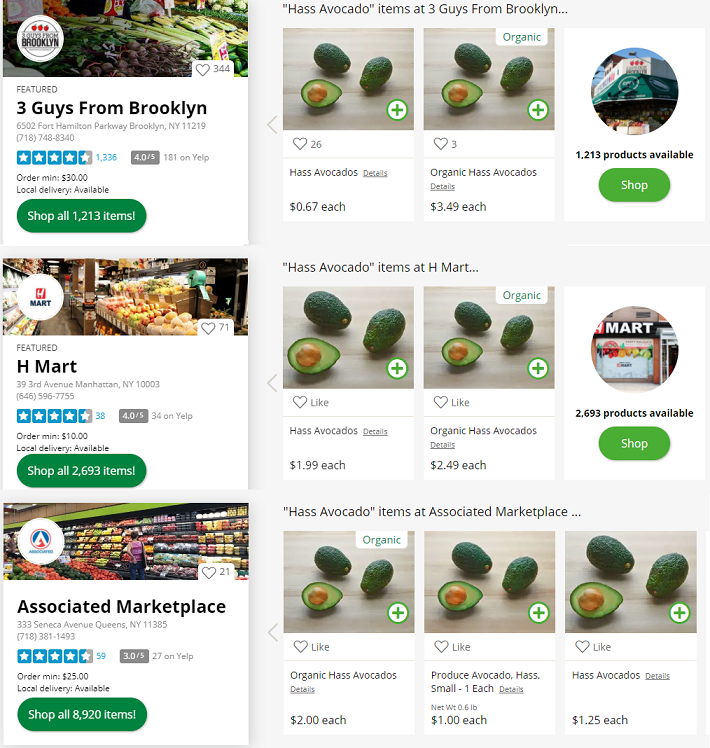

In [ ]:
for q,pred in ny_predictions.items():
  print("quantile alpha: {}".format(q))
  print(pred)
  print("-----------------------")

The prices in the picture are bit more expensive than the predictions in case of organic produce. Perhaps if we had more data about recent years like 2018 and 2019, we could make more accurate predicitons.

# References <a name='ref'></a>

1. [Quantile Regression](http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html#Quantile-Regression-With-LightGBM) by Ethen Liu

2. [Quantile Regression PyTorch (tabular data only)](https://www.kaggle.com/carlossouza/quantile-regression-pytorch-tabular-data-only) by Carlos Souza

3. [Thinking beyond the mean: a practical guide for using quantile regression methods for health services research](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4054530/#:~:text=The%20main%20advantage%20of%20quantile,nonlinear%20relationships%20with%20predictor%20variables.) <a name='qrref'></a>

4. [Quantile Regression and Its Applications: A Primer for Anesthesiologists](https://journals.lww.com/anesthesia-analgesia/FullText/2019/04000/Quantile_Regression_and_Its_Applications__A_Primer.28.aspx?casa_token=E9_6Q_Naz2QAAAAA:of4MeENtwAKdmoS26aNlq8XrUawUhPjsNWBdMWwMWrm55JLE8VnqU24-cx3uXiwuxLiBFA9yA6TF5VmydmxgTUM)

5. [Testing Linear Regression Assumptions in Python](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/) by Jeff Macaluso

6. [Outlier!!! The Silent Killer](https://www.kaggle.com/nareshbhat/outlier-the-silent-killer) by Naresh bhat

7. [Regression diagnostics:  testing the assumptions of linear regression](http://people.duke.edu/~rnau/testing.htm)

full code can be found [here](https://github.com/AsalJalilvand/kaggle) 